In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from DataLoader.my_dataloader import get_loader, get_distance_image
from DCNN.model import Model_sep, Model, Ensemble
import torch
from data.prepare_data import (
    get_data_paths,
    missing_PTVs,
    read_data,
    read_all_data,
    delete_duplication,
)
import os

In [2]:
train, val, test = get_loader(
    "data",
    train_bs=32,
    val_bs=1,
    test_bs=1,
    train_num_samples_per_epoch=7800,
    val_num_samples_per_epoch=1200,
    test_num_samples_per_epoch=1200,
    num_works=1,
    resplit=False,
    seed=199,  # 199
    with_miss_PTVs=True,
    with_distance=True,
)

### Data Visualization

In [3]:
plt.rcParams["savefig.bbox"] = "tight"


def show(data, predicted=None):
    CT_scan = data[0][0, 2]
    PTVs = data[0][0, 0]
    OARs = data[0][0, 1]
    Rdose = data[1][0, 0]
    if data[0][0].shape[0] > 3:
        distance_image = data[0][0, 3]
    else:
        distance_image = np.zeros_like(data[1][0, 0])
    if predicted is None:
        a = 5
    else:
        a = 7
    fig, axs = plt.subplots(ncols=a, squeeze=False)
    fig.set_figwidth(20)
    fig.set_figheight(20)

    axs[0, 0].set_title("CT scan")
    axs[0, 0].imshow(CT_scan, cmap="gray")

    axs[0, 1].set_title("PTVs")
    axs[0, 1].imshow(PTVs, cmap="jet")

    axs[0, 2].set_title("Distance transform")
    axs[0, 2].imshow(distance_image, cmap="jet")

    axs[0, 3].set_title("OARs")
    axs[0, 3].imshow(OARs, cmap="jet")

    axs[0, 4].set_title("Radiation dose")
    axs[0, 4].imshow(Rdose, cmap="jet")

    if predicted is not None:
        axs[0, 5].set_title("predicted Radiation dose")
        axs[0, 5].imshow(predicted, cmap="jet")

        axs[0, 6].set_title("Difference")
        axs[0, 6].imshow(np.abs(predicted - Rdose), cmap="jet")
    plt.show()

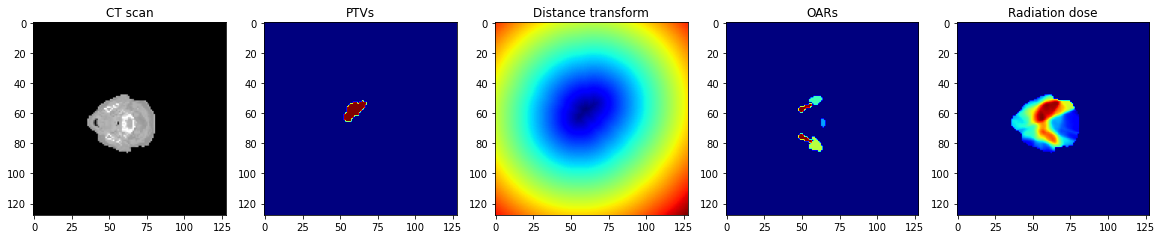

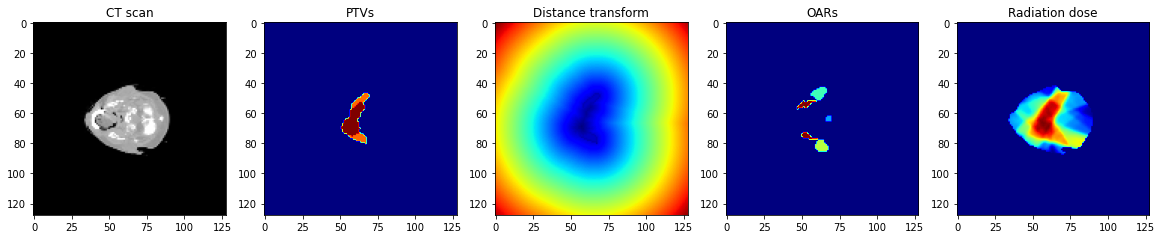

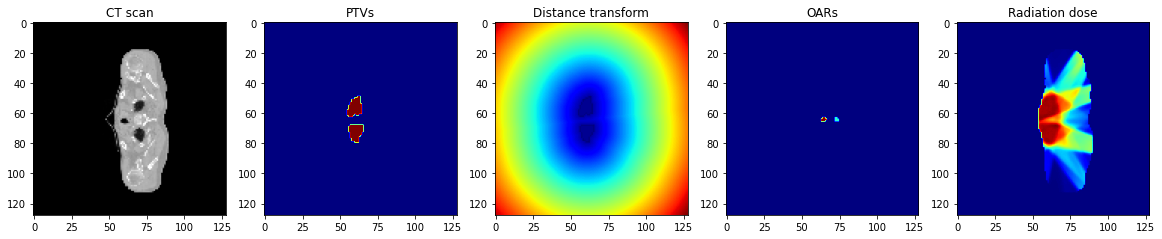

In [6]:
for batch_idx, list_loader_output in enumerate(val):
    show(list_loader_output[0]["data"])
    if batch_idx == 2:
        break

### Data Duplication

In [188]:
def condition(b):
    return "sample" in b and ("train" in b or "val" in b or "test" in b)


train_val = np.sort([a[0] for a in os.walk("data/") if condition(a[0])])

In [191]:
d = read_all_data(train_val)

reading all the data


10200it [01:23, 122.89it/s]


In [207]:
samples, indices = np.unique(d, axis=0, return_index=True)

In [208]:
print(
    f"We have in our train and validation sets only {samples.shape[0]} unique images from {d.shape[0]}"
)

We have in our train and validation sets only 8051 unique images from 10200


In [ ]:
# we can use delete_duplication function to delete these duplications
# delete_duplication(train_val)

reading all the data


9000it [01:12, 124.85it/s]


Find unique samples
Deleting duplicated sampeles
1876 duplicated samples found


100%|██████████| 1876/1876 [00:02<00:00, 657.03it/s]


### Missing PTVs

In [7]:
dir = "data/"
data_paths = get_data_paths(dir)
missing_indices = missing_PTVs(data_paths, indices=False)
print(
    f"We have in our datasets {len(missing_indices)} samples with empty PTVs from {len(data_paths)}"
)

10200it [03:30, 48.54it/s]

We have in our datasets 831 samples with empty PTVs from 10200


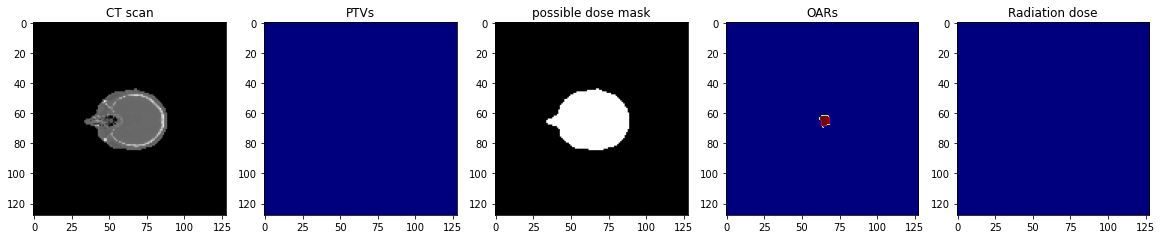

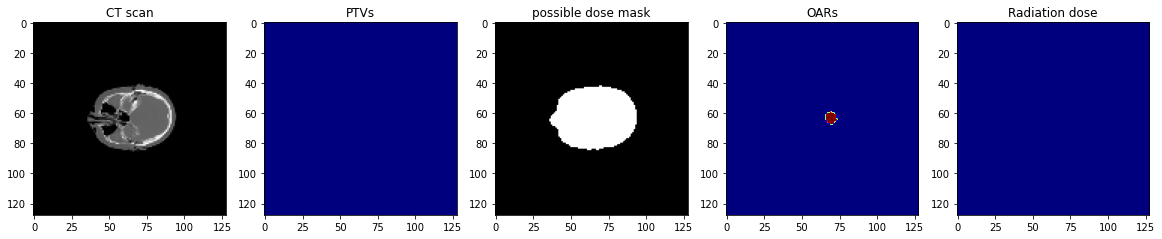

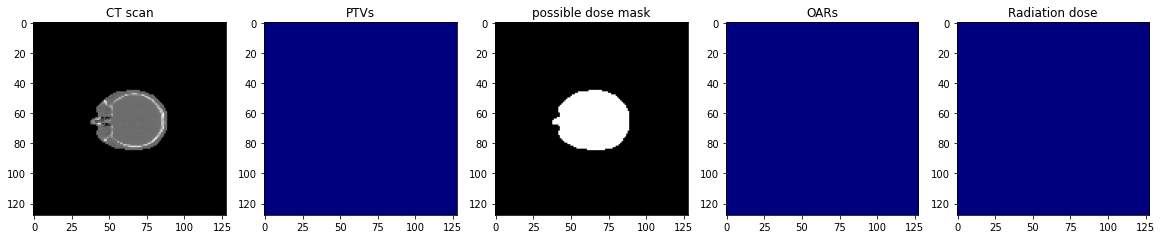

In [8]:
for p in missing_indices[:3]:
    if "test" not in p:
        continue
    dict = read_data(p)
    CT_scan = dict[2]
    PTVs = dict[0]
    OARs = dict[1]
    Rdose = dict[-1]
    mask = dict[3] > 0
    fig, axs = plt.subplots(ncols=5, squeeze=False)
    fig.set_figwidth(20)
    fig.set_figheight(20)

    axs[0, 0].set_title("CT scan")
    axs[0, 0].imshow(CT_scan, cmap="gray")
    # axs[0, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    axs[0, 1].set_title("PTVs")
    axs[0, 1].imshow(PTVs, cmap="jet")

    axs[0, 2].set_title("possible dose mask")
    axs[0, 2].imshow(mask, cmap="gray")

    axs[0, 3].set_title("OARs")
    axs[0, 3].imshow(OARs, cmap="jet")

    axs[0, 4].set_title("Radiation dose")
    axs[0, 4].imshow(Rdose, cmap="jet")
    plt.show()

#### Predict missing PTVs using CT scan and OARs

In [4]:
_, val_ptv_est, _ = get_loader(
    "data",
    train_bs=32,
    val_bs=1,
    test_bs=1,
    train_num_samples_per_epoch=7800,  # 5000 iterations per epoch
    val_num_samples_per_epoch=1200,
    test_num_samples_per_epoch=1200,
    num_works=1,
    resplit=False,
    seed=199,  # 199
    with_miss_PTVs=True,
    with_distance=True,
    PTV_estimate=True,
)
path = "Output/DCNN_None_ROI_LOSS_ptv1/best_val_evaluation_uloss.pkl"

model_ptv = Model(in_ch=2, out_ch=5, list_ch=[-1, 32, 64, 128, 256], PTV_estimator=True)
model_ptv.load_state_dict(torch.load(path)["network_state_dict"])
model_ptv = model_ptv.eval()

# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !


0it [00:00, ?it/s]

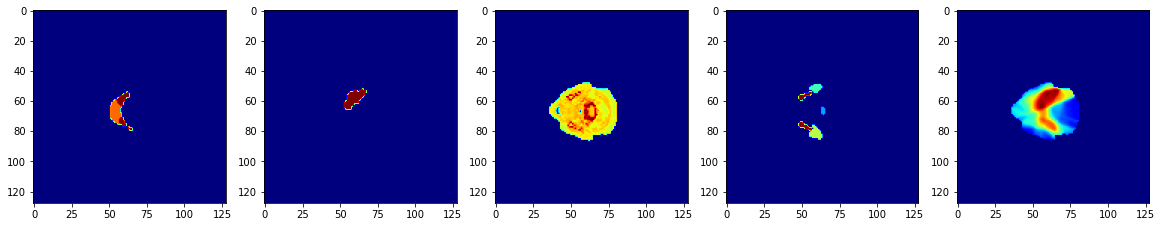

1it [00:00,  1.29it/s]

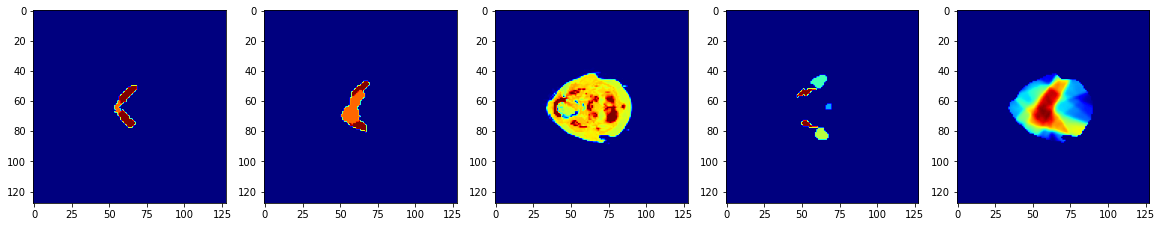

2it [00:01,  1.81it/s]

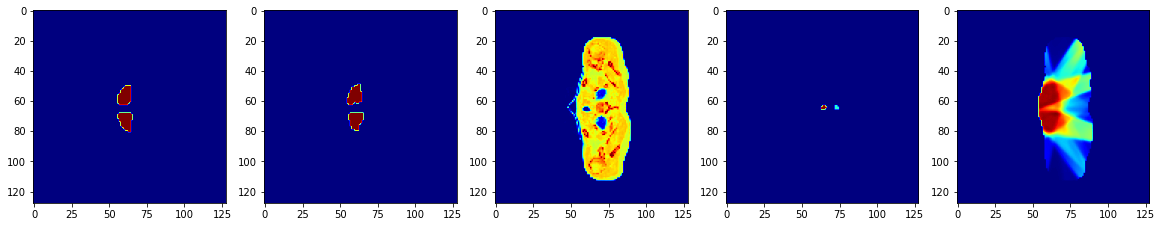

3it [00:01,  2.05it/s]

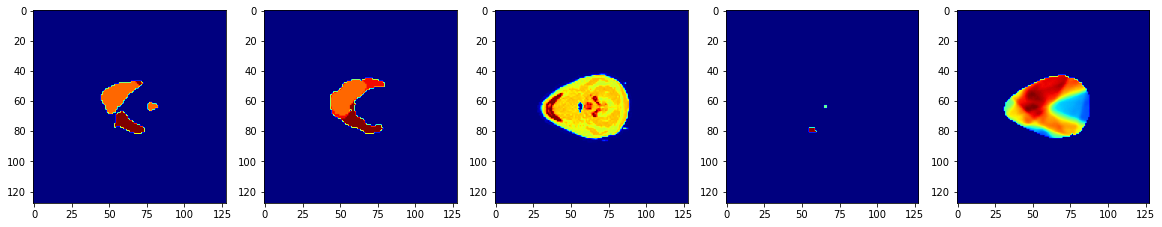

4it [00:02,  1.94it/s]

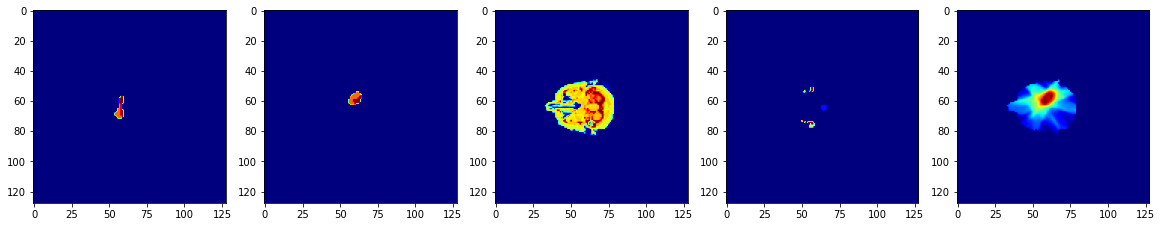

5it [00:02,  2.16it/s]

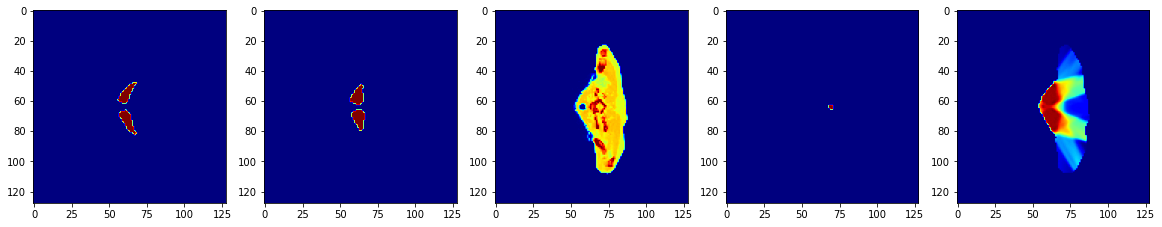

5it [00:02,  1.74it/s]


In [6]:
for batch_idx, list_loader_output in tqdm(enumerate(val_ptv_est)):
    # List_loader_output[0] default as the input
    path = list_loader_output[1][0]
    input_ = list_loader_output[0]["data"][0]
    target = list_loader_output[0]["data"][1][0]
    dose = list_loader_output[0]["data"][3][0]
    mask = list_loader_output[0]["data"][2][0][0]
    output = model_ptv(input_)
    fig, axs = plt.subplots(ncols=5, squeeze=False)
    fig.set_figwidth(20)
    fig.set_figheight(20)
    output = 4 - output[0].detach()[0].numpy().argmax(axis=0)
    output[output <= 1] = 0
    ptv_pred = 1.0 * (output == 4) + 63 / 70 * (output == 3) + 56 / 70 * (output == 2)
    ptv_gt = 1.0 * target[0] + 63 / 70 * target[1] + 56 / 70 * target[2]
    axs[0, 0].imshow(ptv_pred * mask.detach().numpy(), cmap="jet")

    axs[0, 1].imshow(ptv_gt, cmap="jet")

    axs[0, 2].imshow(input_[0, 0], cmap="jet")

    axs[0, 3].imshow(input_[0, 1], cmap="jet")

    axs[0, 4].imshow(dose[0], cmap="jet")
    plt.show()
    if batch_idx >= 5:
        break

### Test the trained models

#### Single Model

Available models:

- 0: DCNN DFA ROI_SM
- 1: DCNN Vit ROI_SM
- 2: DCNN DFA WD ROI_SM
- 3: DCNN GAN DFA ROI_SM
- 4: DCNN_2ENC DFA ROI_SM
- 5: AUTOENC DFA ROI_SM
- 6: AUTOENC None ROI_SM

In [7]:
# available models
path = [
    "Output/DCNN__DFA_ROI_SM",
    "Output/DCNN__DFA_ROI",
    "Output/DCNN__Vit_ROI_SM",
    "Output/DCNN__DFA_ROI_SM_WD",
    "Output/DCNN_GAN_DFA_ROI_SM",
    "Output/DCNN_2ENC__DFA_ROI_SM",
    "Output/DCNN_2ENC__DFA_ROI",
    "Output/AUTOENC__DFA_ROI_SM",
    "Output/AUTOENC__NONE_ROI_SM",
][0]



model_PATH = path + "/best_val_evaluation_uloss.pkl"
PATH_OUT = path + "/output"

if not os.path.exists(PATH_OUT):
    os.mkdir(PATH_OUT)

in_ch = 3 if "WD" in path else 4

bottleneck = "DFA"
if "Vit" in path:
    bottleneck = "Vit"
elif "NONE" in path:
    bottleneck = None

Unet = False if "AUTOENC" in path else True

if "2ENC" in path:
    model = Model_sep(
        in_ch=in_ch,
        out_ch=1,
        list_ch=[-1, 32, 64, 128, 256],
        bottleneck=bottleneck,
        Unet=Unet,
    )
else:
    model = Model(
        in_ch=in_ch,
        out_ch=1,
        list_ch=[-1, 32, 64, 128, 256],
        bottleneck=bottleneck,
        Unet=Unet,
    )

model.load_state_dict(torch.load(model_PATH)["network_state_dict"])
model = model.eval()

# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !


In [4]:
_, val, _ = get_loader(
    "data",
    train_bs=32,
    val_bs=1,
    test_bs=1,
    train_num_samples_per_epoch=7800,  # 5000 iterations per epoch
    val_num_samples_per_epoch=1200,
    test_num_samples_per_epoch=1200,
    num_works=1,
    resplit=False,
    seed=199,  # 199
    with_miss_PTVs=True,
    with_distance=False if "WD" in path else True,
)

0it [00:00, ?it/s]

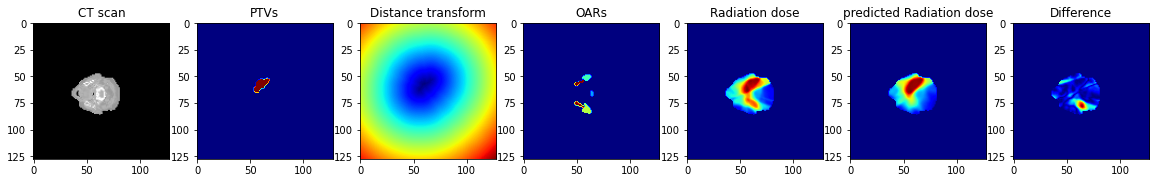

1it [00:00,  1.43it/s]

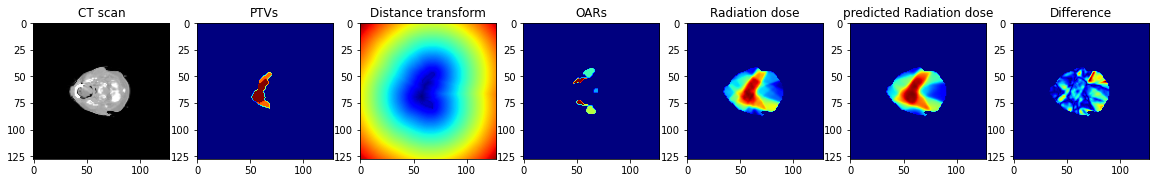

1200it [00:36, 32.60it/s]


In [8]:
from DCNN.loss import L1Loss

loss_artif = []
loss = []
Visualize = True

loss_fn = L1Loss()

for batch_idx, list_loader_output in tqdm(enumerate(val)):
    # List_loader_output[0] default as the input
    path = list_loader_output[1][0]
    input_ = list_loader_output[0]["data"][0]
    target = list_loader_output[0]["data"][1][0][0]
    mask = list_loader_output[0]["data"][2][0][0]
    if input_[0][0].sum() != 0:
        output = model(input_)[0]
        loss.append(float(loss_fn(output[0], [target, mask])))
        if batch_idx < 2 and Visualize:
            show(list_loader_output[0]["data"], output.detach()[0][0] * mask)
    else:
        output = model(input_)[0]
        loss_artif.append(float(loss_fn(output[0], [target, mask])))
        if batch_idx < 2 and Visualize:
            show(list_loader_output[0]["data"], output.detach()[0][0] * mask)

In [28]:
# DCNN DFA
print(
    f"MAE of the predicted radiation dose in the validation set: %.4f"
    % np.mean(loss + loss_artif)
)

MAE of the predicted radiation dose in the validation set: 0.3850


In [36]:
# DCNN Vit
print(
    f"MAE of the predicted radiation dose in the validation set: %.4f"
    % np.mean(loss + loss_artif)
)

MAE of the predicted radiation dose in the validation set: 0.3847


In [45]:
# DCNN DFA Without distance
print(
    f"MAE of the predicted radiation dose in the validation set: %.4f"
    % np.mean(loss + loss_artif)
)

MAE of the predicted radiation dose in the validation set: 0.3873


In [51]:
# DCNN DFA With adversarial loss
print(
    f"MAE of the predicted radiation dose in the validation set: %.4f"
    % np.mean(loss + loss_artif)
)

MAE of the predicted radiation dose in the validation set: 0.3872


In [54]:
# DCNN_2ENC DFA
print(
    f"MAE of the predicted radiation dose in the validation set: %.4f"
    % np.mean(loss + loss_artif)
)

MAE of the predicted radiation dose in the validation set: 0.3816


In [57]:
# AutoEnc DFA
print(
    f"MAE of the predicted radiation dose in the validation set: %.4f"
    % np.mean(loss + loss_artif)
)

MAE of the predicted radiation dose in the validation set: 0.3775


In [60]:
# AutoEnc NONE
print(
    f"MAE of the predicted radiation dose in the validation set: %.4f"
    % np.mean(loss + loss_artif)
)

MAE of the predicted radiation dose in the validation set: 0.3904


#### Ensemble

In [12]:
paths = [
    "Output/DCNN__DFA_ROI_SM/best_val_evaluation_uloss.pkl",
    "Output/DCNN__DFA_ROI/best_val_evaluation_uloss.pkl",
    "Output/DCNN__Vit_ROI_SM/best_val_evaluation_uloss.pkl",
    "Output/DCNN_GAN_DFA_ROI_SM/best_val_evaluation_uloss.pkl",
    "Output/DCNN_2ENC__DFA_ROI_SM/best_val_evaluation_uloss.pkl",
    "Output/AUTOENC__DFA_ROI_SM/best_val_evaluation_uloss.pkl"
]
models = []

model1 = Model(in_ch=4, out_ch=1, list_ch=[-1, 32, 64, 128, 256], bottleneck="DFA")
model2 = Model(in_ch=4, out_ch=1, list_ch=[-1, 32, 64, 128, 256], bottleneck="DFA")
model3 = Model(in_ch=4, out_ch=1, list_ch=[-1, 32, 64, 128, 256], bottleneck="Vit")
model4 = Model(in_ch=4, out_ch=1, list_ch=[-1, 32, 64, 128, 256], bottleneck="DFA")

model5 = Model_sep(in_ch=4, out_ch=1, list_ch=[-1, 32, 64, 128, 256])

model6 = Model(
    in_ch=4, out_ch=1, list_ch=[-1, 32, 64, 128, 256], Unet=False, bottleneck="DFA"
)

model1.load_state_dict(torch.load(paths[0])["network_state_dict"])
models.append(model1)
model2.load_state_dict(torch.load(paths[1])['network_state_dict'])
models.append(model2)
model3.load_state_dict(torch.load(paths[2])['network_state_dict'])
models.append(model3)
model4.load_state_dict(torch.load(paths[3])['network_state_dict'])
models.append(model4)
model5.load_state_dict(torch.load(paths[4])["network_state_dict"])
models.append(model5)
model6.load_state_dict(torch.load(paths[5])["network_state_dict"])
models.append(model6)

# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !


/home/infres/ahmad-21/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !


In [13]:
PATH_OUT = "Output/ENSEMBLE/output"
model1 = Ensemble(models)
model2 = Ensemble([models[4],models[5]])

In [14]:
_, val, test = get_loader(
    "data",
    train_bs=32,
    val_bs=1,
    test_bs=1,
    train_num_samples_per_epoch=7800,
    val_num_samples_per_epoch=1200,
    test_num_samples_per_epoch=1200,
    num_works=1,
    resplit=False,
    seed=199,  # 199
    with_miss_PTVs=True,
    with_distance=True,
)

0it [00:00, ?it/s]

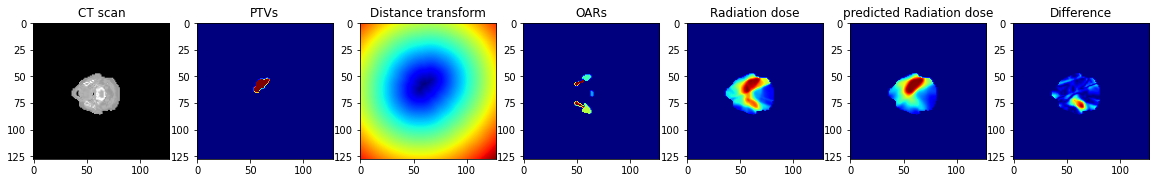

1it [00:01,  1.13s/it]

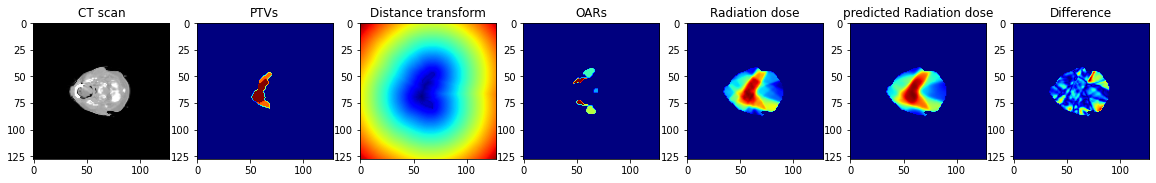

2it [00:01,  1.06it/s]

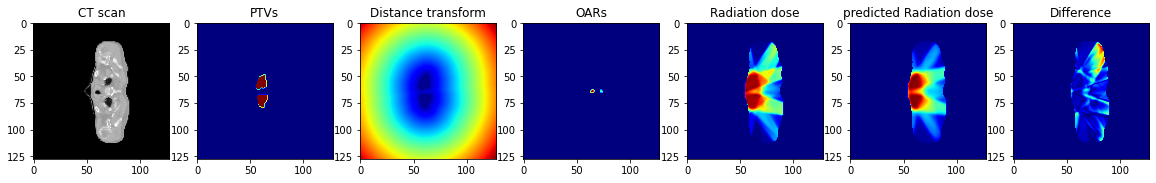

3it [00:02,  1.09it/s]

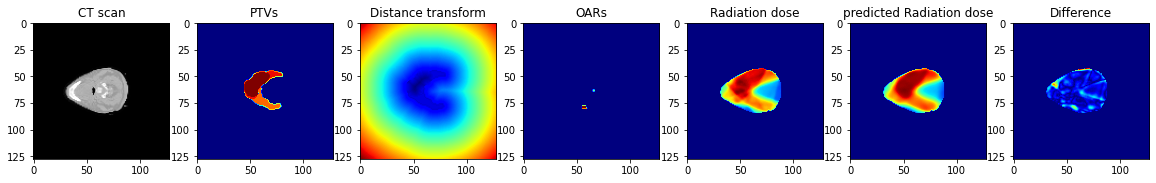

4it [00:03,  1.00s/it]

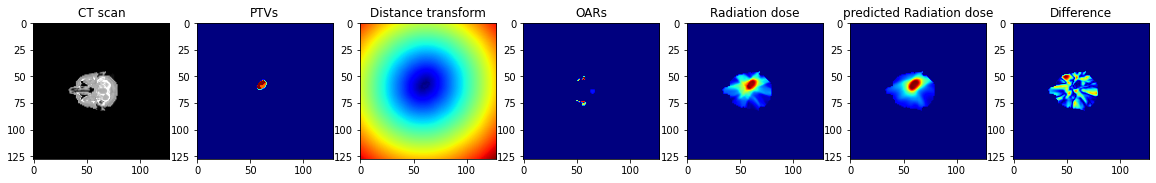

1200it [07:51,  2.55it/s]


In [17]:
from DCNN.loss import L1Loss

loss_artif = []
loss = []
Visualize = True

loss_fn = L1Loss()

for batch_idx, list_loader_output in tqdm(enumerate(val)):
    # List_loader_output[0] default as the input
    path = list_loader_output[1][0]
    input_ = list_loader_output[0]["data"][0]
    target = list_loader_output[0]["data"][1][0][0]
    mask = list_loader_output[0]["data"][2][0][0]
    if input_[0][0].sum() != 0:
        output = model1(input_)[0][0]
        loss.append(float(loss_fn(output, [target, mask])))
        if batch_idx < 5 and Visualize:
            show(list_loader_output[0]["data"], output[0].detach() * mask)
    else:
        output = model2(input_)[0][0]
        loss_artif.append(float(loss_fn(output, [target, mask])))
        if batch_idx < 5 and Visualize:
            show(list_loader_output[0]["data"], output[0].detach()[0] * mask)

In [72]:
# Ensemble 6 models
print(
    f"MAE of the predicted radiation dose in the validation set: %.4f"
    % np.mean(loss + loss_artif)
)
np.mean(loss), np.mean(loss_artif), np.mean(loss_artif + loss)

MAE of the predicted radiation dose in the validation set: 0.3538


(0.34648069036576473, 0.4077067207219405, 0.3537767923165423)